In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/nerf

/content/drive/.shortcut-targets-by-id/1dnqxksOTC7l6q9Qbb79NezV8kroYRDZe/nerf


In [ ]:
!nvidia-smi

Thu Jun 24 16:46:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install einops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gc
from math import exp
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, mask, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    ssim_map = ssim_map*mask

    if size_average:
        return (ssim_map.mean(1).mean(1).mean(1)/mask.mean(1).mean(1).mean(1)).mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)/mask.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2, mask):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, mask, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, mask, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
def create_enc(in_dim, dim, head_num, head_dim, layer_num):
  net = nn.Sequential(
      *[
       nn.Sequential(
        nn.Conv3d(in_dim if i==0 else dim//2**(layer_num-i),dim//2**(layer_num-i-1),(1,4,4),stride=(1,2,2),padding=(0,1,1)),
        nn.ReLU(),
        nn.GroupNorm(1,dim//2**(layer_num-i-1)), 
       ) for i in range(layer_num)
      ],

      nn.Conv3d(dim,head_num*head_dim,1),
    )
  return net

In [ ]:
# v_net = create_enc(3,128,8,64,2)
# k_net = create_enc(39,128,8,64,2)
# q_net = create_enc(39,256,8,64,3)
# values = v_net(torch.randn(1,3,10,64,64))
# keys = k_net(torch.randn(1,39,10,64,64))
# querys = q_net(torch.randn(2,39,64,64,64))
# values.shape, keys.shape, querys.shape

In [ ]:
def mapping(q, k, v, head_num):
  b, c, D, H, W = q.shape
  dk = c/head_num

  q = rearrange(q, 'b (h d) D H W -> b h (D H W) d', h=head_num)
  k = rearrange(k, 'b (h d) D H W -> b h (D H W) d', h=head_num)
  v = rearrange(v, 'b (h d) D H W -> b h (D H W) d', h=head_num)

  map = torch.softmax(torch.einsum('bhLd,bhSd->bhLS', q, k)/(dk**0.5), -1)
  head_out = torch.einsum('bhLS,bhSd->bhLd', map, v)
  mu, logvar = rearrange(head_out, 'b h (D H W) (k d) -> k b (h d) D H W', D=D, H=H, W=W, k=2)[:,...]
    
  return mu, logvar

In [ ]:
def reparameterize(mu, logvar):
  std = logvar.mul(0.5).exp_()
  # return torch.normal(mu, std)
  esp = torch.randn_like(mu)
  z = mu + std * esp
  return z

In [ ]:
def kl_divergence(mu, logvar):
  return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
# z = mapping(querys, keys, values, 8)
# z.shape

In [ ]:
def create_dec(out_dim, dim, head_num, head_dim, layer_num):
  net = nn.Sequential(
      nn.Conv3d(head_num*head_dim,head_num*head_dim,(1,3,3),padding=(0,1,1),groups=head_num),
      nn.ReLU(),
      nn.GroupNorm(1,head_num*head_dim),
      nn.Conv3d(head_num*head_dim,dim,1,),
      nn.ReLU(),
      nn.GroupNorm(1,dim),

      *[
       nn.Sequential(
        nn.ConvTranspose3d(dim//2**i,dim//2**(i+1),(1,4,4),stride=(1,2,2),padding=(0,1,1),),
        nn.ReLU(),
        nn.GroupNorm(1,dim//2**(i+1)),
       ) for i in range(layer_num)
      ],

      nn.Conv3d(dim//2**(layer_num),out_dim,1),
    )
  return net

In [ ]:
# dec_net = create_dec(4, 256, 8, 64, 3)
# dec_net(z).shape

In [ ]:
def load_data(path):
  data = np.load(path, allow_pickle=True)
  imgs = data["imgs"]
  poses = data["poses"]
  render_poses = data["render_poses"]
  [H, W, focal] = data["hwf"]
  i_split = data["i_split"]
  
  return imgs, poses, render_poses, [H, W, focal], i_split

In [ ]:
objs = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]

imgs = {}
poses = {}
render_poses = {}
hwf = {}
for obj in objs:
  print(obj)
  imgs[obj], poses[obj], render_poses[obj], hwf[obj], _ = load_data("./nerf_synthetic/{}-64.npz".format(obj))
  imgs[obj] = np.transpose(imgs[obj],(0,3,1,2))

chair
drums
ficus
hotdog
lego
materials
mic
ship


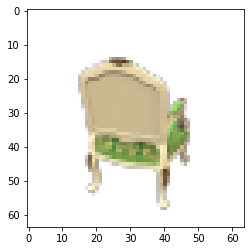

In [ ]:
plt.imshow(np.transpose(imgs[objs[0]][20],(1,2,0)))
plt.show()

In [ ]:
def posenc(pts, L_embed):
  rets = [pts]
  for i in range(L_embed):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i * pts))
  return torch.cat(rets, 1)

def sample_z(near, far, N_samples, H=1, W=1, bz=1, rand=False,):
  z_vals = torch.linspace(near, far, N_samples,).to(device)
  z_vals = repeat(z_vals, 'n -> b 1 n h w', b=bz, h=H, w=W)
  if rand:
    z_vals = z_vals + torch.rand_like(z_vals).to(device) * (far-near)/N_samples
  return z_vals

def sample_points(rays_o, rays_d, z_vals,):
  pts = rays_o[:,:,np.newaxis,...] + rays_d[:,:,np.newaxis,...] * z_vals
  return pts

def get_rays(H, W, focal, c2ws):
  b = c2ws.shape[0]
  # x:(H, W)
  # y:(H, W)
  y ,x = torch.meshgrid(torch.arange(0, H), torch.arange(0, W),)

  # dirs:(3, H, W)
  dirs = torch.stack([(x-W*.5)/focal, -(y-H*.5)/focal, -torch.ones(H,W)], 0).to(device)

  # c2ws[...,:3,:3]:(B, 3, 3)
  # rays_d:(B, 3, H, W)
  rays_d = torch.einsum("vhw,buv->buhw", dirs, c2ws[...,:3,:3])

  # c2w[...,:3,-1]:(B, 3)
  # rays_o:(B, 3, H, W)
  rays_o = torch.broadcast_to(c2ws[...,:3,-1].reshape(b,3,1,1), rays_d.shape)
  return rays_o, rays_d

In [ ]:
bz = 4
acc_bz = 8

near = 2
far = 6
N_samples_range = [16,64]
L_embed = 12

dim = 256
head_num = 32
head_dim = 32

train_objs = objs[:6]
base_num_range = [4, 16]

In [ ]:
v_net = create_enc(3, dim, head_num, head_dim*2, 3).to(device)
k_net = create_enc((L_embed*2+1)*3, dim, head_num, head_dim, 3).to(device)
q_net = create_enc((L_embed*2+1)*3, dim, head_num, head_dim, 3).to(device)
dec_net = create_dec(4, dim, head_num, head_dim, 3).to(device)

opt = optim.Adamax([
      *v_net.parameters(),
      *k_net.parameters(),
      *q_net.parameters(),
      *dec_net.parameters(),
    ])

ssim_fn = SSIM()
mse_fn = nn.MSELoss()

In [ ]:
checkpoint = torch.load("./decoupling_nerf-vae_state.pt")

v_net.load_state_dict(checkpoint['v_net_state_dict'])
k_net.load_state_dict(checkpoint['k_net_state_dict'])
q_net.load_state_dict(checkpoint['q_net_state_dict'])
dec_net.load_state_dict(checkpoint['dec_net_state_dict'])
opt.load_state_dict(checkpoint['opt_state_dict'])

<All keys matched successfully>

[0] SSIM: 0.021


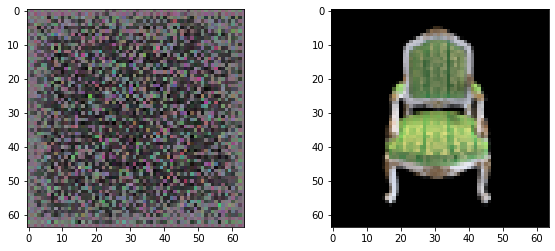

[1] SSIM: 0.025
[2] SSIM: 0.033
[3] SSIM: 0.021
[4] SSIM: 0.037
[5] SSIM: 0.048
[6] SSIM: 0.056
[7] SSIM: 0.060
[8] SSIM: 0.064
[9] SSIM: 0.052
[10] SSIM: 0.074
[11] SSIM: 0.053
[12] SSIM: 0.064
[13] SSIM: 0.092
[14] SSIM: 0.093
[15] SSIM: 0.092
[16] SSIM: 0.088
[17] SSIM: 0.088
[18] SSIM: 0.067
[19] SSIM: 0.071
[20] SSIM: 0.080
[21] SSIM: 0.094
[22] SSIM: 0.083
[23] SSIM: 0.079
[24] SSIM: 0.094
[25] SSIM: 0.088


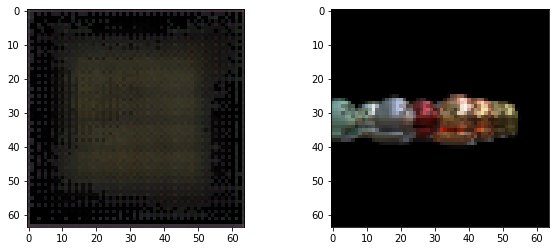

[26] SSIM: 0.094
[27] SSIM: 0.079
[28] SSIM: 0.093
[29] SSIM: 0.105
[30] SSIM: 0.116
[31] SSIM: 0.124
[32] SSIM: 0.121
[33] SSIM: 0.121
[34] SSIM: 0.130
[35] SSIM: 0.127
[36] SSIM: 0.121
[37] SSIM: 0.132
[38] SSIM: 0.125
[39] SSIM: 0.139
[40] SSIM: 0.139
[41] SSIM: 0.146
[42] SSIM: 0.133
[43] SSIM: 0.130
[44] SSIM: 0.151
[45] SSIM: 0.149
[46] SSIM: 0.152
[47] SSIM: 0.146
[48] SSIM: 0.149
[49] SSIM: 0.151
[50] SSIM: 0.156


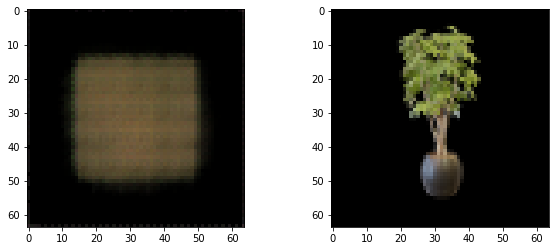

[51] SSIM: 0.169
[52] SSIM: 0.162
[53] SSIM: 0.149
[54] SSIM: 0.181
[55] SSIM: 0.175
[56] SSIM: 0.180
[57] SSIM: 0.194
[58] SSIM: 0.188
[59] SSIM: 0.180
[60] SSIM: 0.171
[61] SSIM: 0.193
[62] SSIM: 0.193
[63] SSIM: 0.190
[64] SSIM: 0.206
[65] SSIM: 0.185
[66] SSIM: 0.194
[67] SSIM: 0.193
[68] SSIM: 0.192
[69] SSIM: 0.200
[70] SSIM: 0.195
[71] SSIM: 0.180
[72] SSIM: 0.189
[73] SSIM: 0.195
[74] SSIM: 0.178
[75] SSIM: 0.192


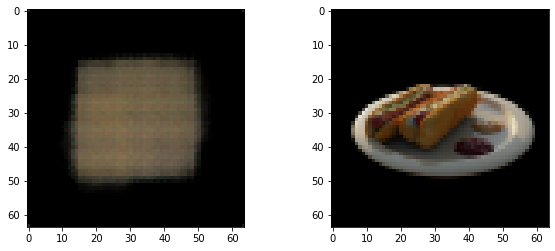

[76] SSIM: 0.186
[77] SSIM: 0.204
[78] SSIM: 0.191
[79] SSIM: 0.205
[80] SSIM: 0.190
[81] SSIM: 0.203
[82] SSIM: 0.195
[83] SSIM: 0.187
[84] SSIM: 0.206
[85] SSIM: 0.199
[86] SSIM: 0.189
[87] SSIM: 0.206
[88] SSIM: 0.201
[89] SSIM: 0.195
[90] SSIM: 0.205
[91] SSIM: 0.207
[92] SSIM: 0.215
[93] SSIM: 0.219
[94] SSIM: 0.192
[95] SSIM: 0.225
[96] SSIM: 0.196
[97] SSIM: 0.190
[98] SSIM: 0.197
[99] SSIM: 0.219
[100] SSIM: 0.194


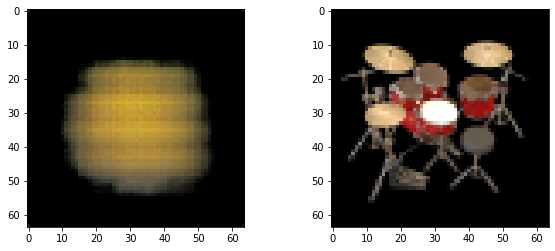

[101] SSIM: 0.203
[102] SSIM: 0.214
[103] SSIM: 0.204
[104] SSIM: 0.215
[105] SSIM: 0.221
[106] SSIM: 0.205
[107] SSIM: 0.218
[108] SSIM: 0.226
[109] SSIM: 0.211
[110] SSIM: 0.209
[111] SSIM: 0.201
[112] SSIM: 0.205
[113] SSIM: 0.208
[114] SSIM: 0.204
[115] SSIM: 0.233
[116] SSIM: 0.206
[117] SSIM: 0.222
[118] SSIM: 0.232
[119] SSIM: 0.219
[120] SSIM: 0.212
[121] SSIM: 0.228
[122] SSIM: 0.211
[123] SSIM: 0.234
[124] SSIM: 0.201
[125] SSIM: 0.203


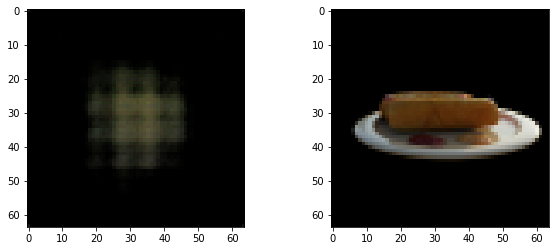

[126] SSIM: 0.205
[127] SSIM: 0.199
[128] SSIM: 0.201
[129] SSIM: 0.225
[130] SSIM: 0.203
[131] SSIM: 0.197
[132] SSIM: 0.222
[133] SSIM: 0.212
[134] SSIM: 0.221
[135] SSIM: 0.218
[136] SSIM: 0.221
[137] SSIM: 0.225
[138] SSIM: 0.213
[139] SSIM: 0.210
[140] SSIM: 0.226
[141] SSIM: 0.211
[142] SSIM: 0.234
[143] SSIM: 0.220
[144] SSIM: 0.236
[145] SSIM: 0.203
[146] SSIM: 0.247
[147] SSIM: 0.229
[148] SSIM: 0.213
[149] SSIM: 0.233
[150] SSIM: 0.245


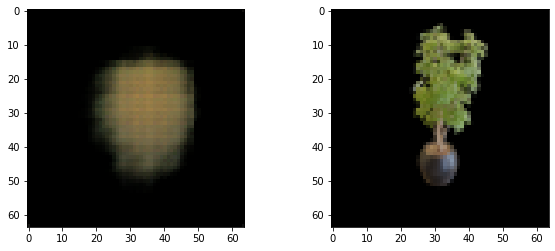

[151] SSIM: 0.242
[152] SSIM: 0.217
[153] SSIM: 0.232
[154] SSIM: 0.202
[155] SSIM: 0.246
[156] SSIM: 0.238
[157] SSIM: 0.219
[158] SSIM: 0.239
[159] SSIM: 0.228
[160] SSIM: 0.250
[161] SSIM: 0.212
[162] SSIM: 0.231
[163] SSIM: 0.281
[164] SSIM: 0.247
[165] SSIM: 0.265
[166] SSIM: 0.206
[167] SSIM: 0.219
[168] SSIM: 0.213
[169] SSIM: 0.219
[170] SSIM: 0.249
[171] SSIM: 0.223
[172] SSIM: 0.213
[173] SSIM: 0.239
[174] SSIM: 0.216
[175] SSIM: 0.218


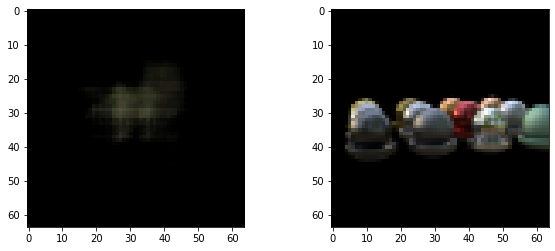

[176] SSIM: 0.246
[177] SSIM: 0.246
[178] SSIM: 0.274
[179] SSIM: 0.205
[180] SSIM: 0.223
[181] SSIM: 0.265
[182] SSIM: 0.214
[183] SSIM: 0.198
[184] SSIM: 0.218
[185] SSIM: 0.265
[186] SSIM: 0.219
[187] SSIM: 0.249
[188] SSIM: 0.205
[189] SSIM: 0.252
[190] SSIM: 0.223
[191] SSIM: 0.261
[192] SSIM: 0.253
[193] SSIM: 0.274
[194] SSIM: 0.244
[195] SSIM: 0.277
[196] SSIM: 0.211
[197] SSIM: 0.233
[198] SSIM: 0.251
[199] SSIM: 0.249


In [ ]:
epochs = 200

indices = np.arange(0,400)

for epoch in range(epochs):
  ssim_val = 0

  opt.zero_grad()

  for bidx in range(acc_bz):
    gc.collect()
    torch.cuda.empty_cache()

    random.shuffle(train_objs)
    train_obj = train_objs[0]

    # base_num = 16
    base_num = random.randint(base_num_range[0], base_num_range[1])
    np.random.shuffle(indices)
    base_idx = indices[:bz]
    target_idx = indices[:bz]
    
    base_img = torch.tensor(imgs[train_obj][base_idx,:-1,...]).type(torch.FloatTensor).to(device)
    base_img = rearrange(base_img, 'b c H W -> b c 1 H W')
    
    target_img = torch.tensor(imgs[train_obj][target_idx,:-1,...]).type(torch.FloatTensor).to(device)
    target_mask = torch.tensor(imgs[train_obj][target_idx,-1:,...]).type(torch.FloatTensor).to(device)

    # N_samples = 64
    N_samples = random.randint(N_samples_range[0], N_samples_range[1])

    H, W, focal = hwf[train_obj]
    H, W = int(H), int(W)
    
    base_rays_o, base_rays_d = get_rays(H, W, focal, torch.tensor(poses[train_obj][base_idx],device=device))
    base_z_vals = sample_z(near, far, 1, 1, 1, 1)
    base_pts = sample_points(base_rays_o, base_rays_d, base_z_vals)
    base_pos = posenc(base_pts, L_embed)
    # base_pos = rearrange(base_pos, 'b e 1 H W -> 1 e b H W')

    target_rays_o, target_rays_d = get_rays(H, W, focal, torch.tensor(poses[train_obj][target_idx],device=device))
    target_z_vals = sample_z(near, far, N_samples, 1, 1, bz, True)
    target_pts = sample_points(target_rays_o, target_rays_d, target_z_vals)
    target_pos = posenc(target_pts, L_embed)

    q = q_net(target_pos)
    k = k_net(base_pos)
    v = v_net(base_img)
    mu, logvar = mapping(q, k, v, head_num)
    z = reparameterize(mu, logvar)
    rgba = dec_net(z)

    rgb = torch.sigmoid(rgba[:,:3,...])
    sigma_a = F.relu(rgba[:,3:,...])
    
    # Do volume rendering
    dists = torch.cat([target_z_vals[:,:,1:,...] - target_z_vals[:,:,:-1,...], torch.ones(bz, 1, 1, 1, 1, device=device)*1e10], 2) 
    alpha = 1.-torch.exp(-sigma_a * dists)
    _alpha = (1.-alpha + 1e-10)[:,:,:-1,...]
    _alpha = torch.cat([torch.ones(bz, 1, 1, H, W, device=device), _alpha],2)
    weights = alpha * torch.cumprod(_alpha, 2)
    rgb_map = torch.sum(weights * rgb, 2)

    ssim_loss = ssim_fn(rgb_map,target_img,target_mask)*0.8+ssim_fn(rgb_map,target_img,1-target_mask)*0.2
    mse_loss = mse_fn(rgb_map,target_img)
    loss = mse_loss*(1-epoch/epochs)-ssim_loss*(epoch/epochs)+kl_divergence(mu, logvar)
    (loss/acc_bz).backward()
    ssim_val += ssim_loss.item()

  opt.step()

  print('[{}] SSIM: {:.3f}'.format(epoch, ssim_val/acc_bz))
  state = {
      'v_net_state_dict': v_net.state_dict(),
      'k_net_state_dict': k_net.state_dict(),
      'q_net_state_dict': q_net.state_dict(),
      'dec_net_state_dict': dec_net.state_dict(),
    }

  torch.save(state, "./decoupling_nerf-vae_state.pt")

  if epoch%25 == 0:
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(np.transpose(rgb_map[0].cpu().detach().numpy(),(1,2,0)))
    plt.subplot(122)
    plt.imshow(np.transpose(target_img[0].cpu().detach().numpy(),(1,2,0)))
    plt.show()
      

[0] SSIM: 0.415


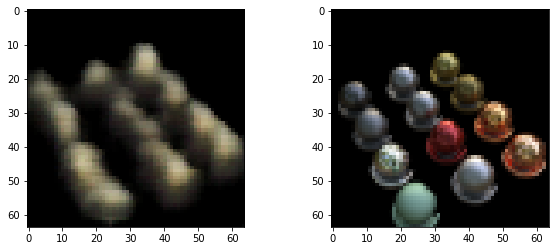

[1] SSIM: 0.174
[2] SSIM: 0.180
[3] SSIM: 0.208
[4] SSIM: 0.218
[5] SSIM: 0.217
[6] SSIM: 0.242
[7] SSIM: 0.258
[8] SSIM: 0.247
[9] SSIM: 0.242
[10] SSIM: 0.238
[11] SSIM: 0.261
[12] SSIM: 0.236
[13] SSIM: 0.269
[14] SSIM: 0.263
[15] SSIM: 0.262
[16] SSIM: 0.275
[17] SSIM: 0.289
[18] SSIM: 0.293
[19] SSIM: 0.281
[20] SSIM: 0.318
[21] SSIM: 0.289
[22] SSIM: 0.274
[23] SSIM: 0.273
[24] SSIM: 0.242
[25] SSIM: 0.277


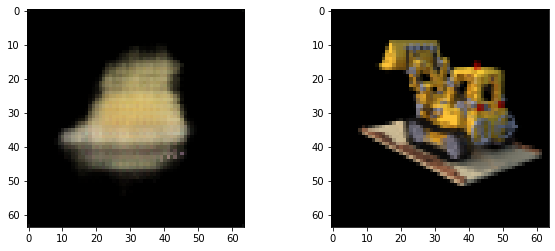

[26] SSIM: 0.256
[27] SSIM: 0.367
[28] SSIM: 0.283
[29] SSIM: 0.297
[30] SSIM: 0.305
[31] SSIM: 0.349
[32] SSIM: 0.274
[33] SSIM: 0.304
[34] SSIM: 0.305
[35] SSIM: 0.261
[36] SSIM: 0.324
[37] SSIM: 0.364
[38] SSIM: 0.319
[39] SSIM: 0.322
[40] SSIM: 0.277
[41] SSIM: 0.283
[42] SSIM: 0.297
[43] SSIM: 0.266
[44] SSIM: 0.278
[45] SSIM: 0.316
[46] SSIM: 0.365
[47] SSIM: 0.401
[48] SSIM: 0.365
[49] SSIM: 0.401
[50] SSIM: 0.385


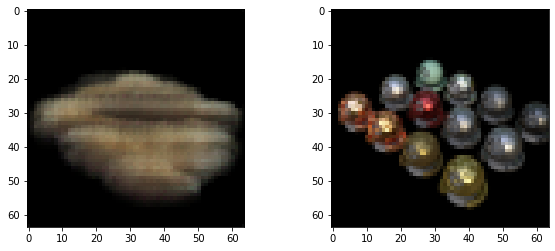

[51] SSIM: 0.289
[52] SSIM: 0.359
[53] SSIM: 0.325
[54] SSIM: 0.352
[55] SSIM: 0.336
[56] SSIM: 0.370
[57] SSIM: 0.372
[58] SSIM: 0.357
[59] SSIM: 0.364
[60] SSIM: 0.394
[61] SSIM: 0.377
[62] SSIM: 0.297
[63] SSIM: 0.307
[64] SSIM: 0.343
[65] SSIM: 0.287
[66] SSIM: 0.316
[67] SSIM: 0.358
[68] SSIM: 0.323
[69] SSIM: 0.319
[70] SSIM: 0.339
[71] SSIM: 0.288
[72] SSIM: 0.353
[73] SSIM: 0.368
[74] SSIM: 0.317
[75] SSIM: 0.394


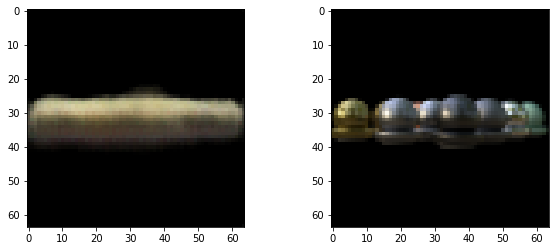

[76] SSIM: 0.320
[77] SSIM: 0.370
[78] SSIM: 0.351
[79] SSIM: 0.313
[80] SSIM: 0.317
[81] SSIM: 0.350
[82] SSIM: 0.355
[83] SSIM: 0.381
[84] SSIM: 0.308
[85] SSIM: 0.295
[86] SSIM: 0.391
[87] SSIM: 0.418
[88] SSIM: 0.385
[89] SSIM: 0.401
[90] SSIM: 0.330
[91] SSIM: 0.387
[92] SSIM: 0.361
[93] SSIM: 0.367
[94] SSIM: 0.372
[95] SSIM: 0.396
[96] SSIM: 0.405
[97] SSIM: 0.397
[98] SSIM: 0.312
[99] SSIM: 0.326
[100] SSIM: 0.396


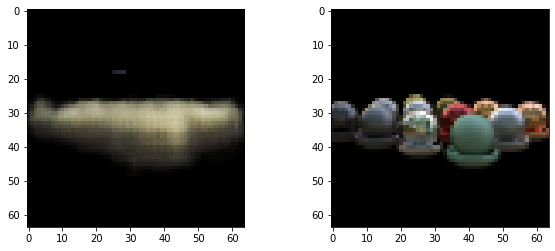

[101] SSIM: 0.337
[102] SSIM: 0.375
[103] SSIM: 0.387
[104] SSIM: 0.416
[105] SSIM: 0.372
[106] SSIM: 0.423
[107] SSIM: 0.371
[108] SSIM: 0.417
[109] SSIM: 0.398
[110] SSIM: 0.393
[111] SSIM: 0.380
[112] SSIM: 0.465
[113] SSIM: 0.407
[114] SSIM: 0.437
[115] SSIM: 0.466
[116] SSIM: 0.397
[117] SSIM: 0.369
[118] SSIM: 0.477
[119] SSIM: 0.421
[120] SSIM: 0.381
[121] SSIM: 0.386
[122] SSIM: 0.367
[123] SSIM: 0.387
[124] SSIM: 0.364
[125] SSIM: 0.401


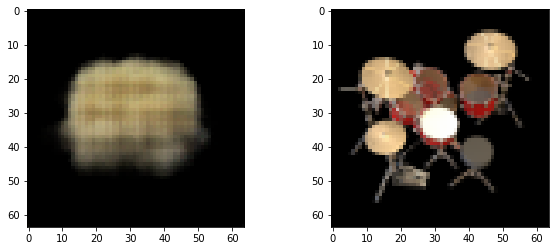

[126] SSIM: 0.367
[127] SSIM: 0.355
[128] SSIM: 0.396
[129] SSIM: 0.400
[130] SSIM: 0.405
[131] SSIM: 0.424
[132] SSIM: 0.391
[133] SSIM: 0.477
[134] SSIM: 0.419
[135] SSIM: 0.401
[136] SSIM: 0.432
[137] SSIM: 0.490
[138] SSIM: 0.321
[139] SSIM: 0.397
[140] SSIM: 0.335
[141] SSIM: 0.399
[142] SSIM: 0.383
[143] SSIM: 0.496
[144] SSIM: 0.416
[145] SSIM: 0.462
[146] SSIM: 0.423
[147] SSIM: 0.329
[148] SSIM: 0.397
[149] SSIM: 0.478
[150] SSIM: 0.399


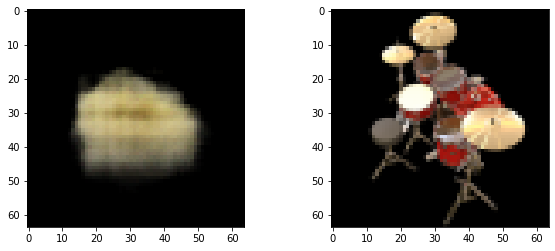

[151] SSIM: 0.465
[152] SSIM: 0.391
[153] SSIM: 0.465
[154] SSIM: 0.455
[155] SSIM: 0.461
[156] SSIM: 0.434
[157] SSIM: 0.469
[158] SSIM: 0.441
[159] SSIM: 0.379
[160] SSIM: 0.421
[161] SSIM: 0.429
[162] SSIM: 0.312
[163] SSIM: 0.425
[164] SSIM: 0.420
[165] SSIM: 0.395
[166] SSIM: 0.397
[167] SSIM: 0.375
[168] SSIM: 0.373
[169] SSIM: 0.438
[170] SSIM: 0.416
[171] SSIM: 0.350
[172] SSIM: 0.380
[173] SSIM: 0.391
[174] SSIM: 0.470
[175] SSIM: 0.502


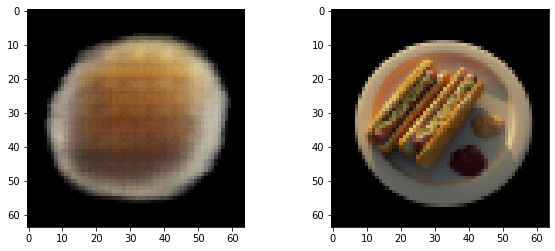

[176] SSIM: 0.477
[177] SSIM: 0.476
[178] SSIM: 0.424
[179] SSIM: 0.455
[180] SSIM: 0.464
[181] SSIM: 0.462
[182] SSIM: 0.438
[183] SSIM: 0.440
[184] SSIM: 0.446
[185] SSIM: 0.362
[186] SSIM: 0.399
[187] SSIM: 0.463
[188] SSIM: 0.449
[189] SSIM: 0.450
[190] SSIM: 0.435
[191] SSIM: 0.390
[192] SSIM: 0.374
[193] SSIM: 0.348
[194] SSIM: 0.426
[195] SSIM: 0.341
[196] SSIM: 0.404
[197] SSIM: 0.343
[198] SSIM: 0.377
[199] SSIM: 0.429
[200] SSIM: 0.454


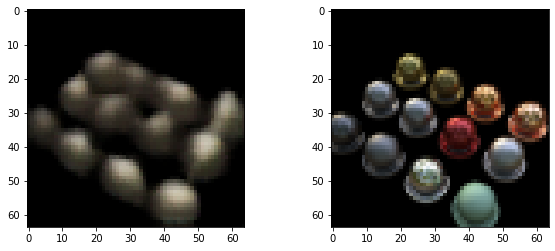

[201] SSIM: 0.444
[202] SSIM: 0.329
[203] SSIM: 0.464
[204] SSIM: 0.411
[205] SSIM: 0.410
[206] SSIM: 0.394
[207] SSIM: 0.367
[208] SSIM: 0.425
[209] SSIM: 0.419
[210] SSIM: 0.430
[211] SSIM: 0.502
[212] SSIM: 0.409
[213] SSIM: 0.456
[214] SSIM: 0.418
[215] SSIM: 0.428
[216] SSIM: 0.494
[217] SSIM: 0.399
[218] SSIM: 0.490
[219] SSIM: 0.415
[220] SSIM: 0.388
[221] SSIM: 0.442
[222] SSIM: 0.446
[223] SSIM: 0.413
[224] SSIM: 0.419
[225] SSIM: 0.390


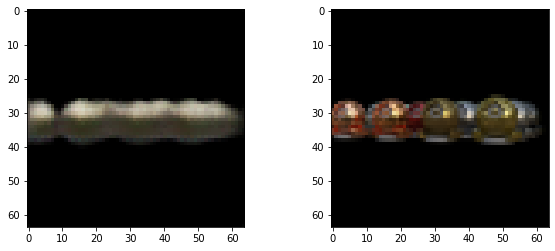

[226] SSIM: 0.396
[227] SSIM: 0.468
[228] SSIM: 0.462
[229] SSIM: 0.518
[230] SSIM: 0.382
[231] SSIM: 0.430
[232] SSIM: 0.468
[233] SSIM: 0.432
[234] SSIM: 0.391
[235] SSIM: 0.377
[236] SSIM: 0.346
[237] SSIM: 0.456
[238] SSIM: 0.441
[239] SSIM: 0.473
[240] SSIM: 0.483
[241] SSIM: 0.474
[242] SSIM: 0.402
[243] SSIM: 0.387
[244] SSIM: 0.489
[245] SSIM: 0.448
[246] SSIM: 0.405
[247] SSIM: 0.405
[248] SSIM: 0.374
[249] SSIM: 0.440
[250] SSIM: 0.473


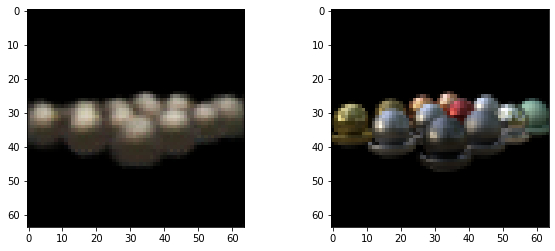

[251] SSIM: 0.456
[252] SSIM: 0.344
[253] SSIM: 0.389
[254] SSIM: 0.389
[255] SSIM: 0.404
[256] SSIM: 0.472
[257] SSIM: 0.452
[258] SSIM: 0.425
[259] SSIM: 0.471
[260] SSIM: 0.392
[261] SSIM: 0.452
[262] SSIM: 0.442
[263] SSIM: 0.446
[264] SSIM: 0.424
[265] SSIM: 0.459
[266] SSIM: 0.472
[267] SSIM: 0.469
[268] SSIM: 0.488
[269] SSIM: 0.418
[270] SSIM: 0.558
[271] SSIM: 0.396
[272] SSIM: 0.380
[273] SSIM: 0.459
[274] SSIM: 0.463
[275] SSIM: 0.465


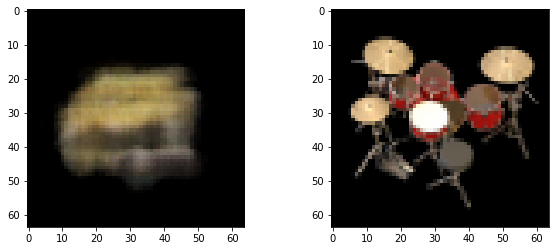

[276] SSIM: 0.465
[277] SSIM: 0.502
[278] SSIM: 0.470
[279] SSIM: 0.492
[280] SSIM: 0.466
[281] SSIM: 0.515
[282] SSIM: 0.443
[283] SSIM: 0.468
[284] SSIM: 0.439
[285] SSIM: 0.475
[286] SSIM: 0.421
[287] SSIM: 0.340
[288] SSIM: 0.453
[289] SSIM: 0.504
[290] SSIM: 0.446
[291] SSIM: 0.439
[292] SSIM: 0.500
[293] SSIM: 0.486
[294] SSIM: 0.417
[295] SSIM: 0.463
[296] SSIM: 0.438
[297] SSIM: 0.427
[298] SSIM: 0.480
[299] SSIM: 0.484
[300] SSIM: 0.455


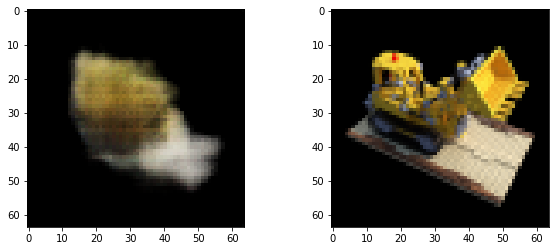

[301] SSIM: 0.424
[302] SSIM: 0.420
[303] SSIM: 0.391
[304] SSIM: 0.407
[305] SSIM: 0.426
[306] SSIM: 0.519
[307] SSIM: 0.584
[308] SSIM: 0.560
[309] SSIM: 0.481
[310] SSIM: 0.468
[311] SSIM: 0.398
[312] SSIM: 0.432
[313] SSIM: 0.452
[314] SSIM: 0.400
[315] SSIM: 0.417
[316] SSIM: 0.527
[317] SSIM: 0.460
[318] SSIM: 0.444
[319] SSIM: 0.540
[320] SSIM: 0.406
[321] SSIM: 0.399
[322] SSIM: 0.448
[323] SSIM: 0.416
[324] SSIM: 0.459
[325] SSIM: 0.493


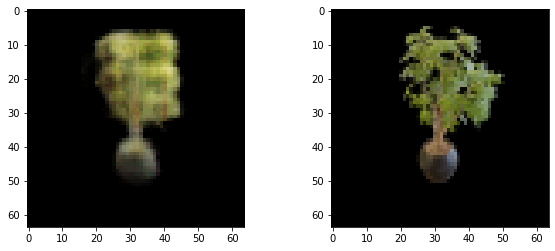

[326] SSIM: 0.498
[327] SSIM: 0.475
[328] SSIM: 0.497
[329] SSIM: 0.433
[330] SSIM: 0.473
[331] SSIM: 0.495
[332] SSIM: 0.479
[333] SSIM: 0.369
[334] SSIM: 0.418
[335] SSIM: 0.386
[336] SSIM: 0.492
[337] SSIM: 0.454
[338] SSIM: 0.424
[339] SSIM: 0.465
[340] SSIM: 0.529
[341] SSIM: 0.446
[342] SSIM: 0.498
[343] SSIM: 0.469
[344] SSIM: 0.470
[345] SSIM: 0.496
[346] SSIM: 0.463
[347] SSIM: 0.485
[348] SSIM: 0.381
[349] SSIM: 0.488
[350] SSIM: 0.418


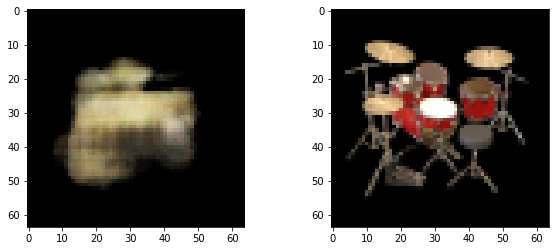

[351] SSIM: 0.492
[352] SSIM: 0.510
[353] SSIM: 0.471
[354] SSIM: 0.492
[355] SSIM: 0.534
[356] SSIM: 0.407
[357] SSIM: 0.481
[358] SSIM: 0.412
[359] SSIM: 0.478
[360] SSIM: 0.508
[361] SSIM: 0.423
[362] SSIM: 0.449
[363] SSIM: 0.533
[364] SSIM: 0.384
[365] SSIM: 0.523
[366] SSIM: 0.498
[367] SSIM: 0.437
[368] SSIM: 0.472
[369] SSIM: 0.464
[370] SSIM: 0.532
[371] SSIM: 0.504
[372] SSIM: 0.414
[373] SSIM: 0.523
[374] SSIM: 0.508
[375] SSIM: 0.571


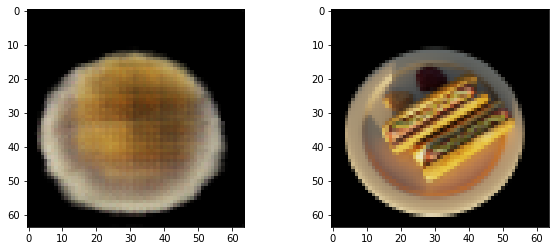

[376] SSIM: 0.447
[377] SSIM: 0.480
[378] SSIM: 0.471
[379] SSIM: 0.504
[380] SSIM: 0.424
[381] SSIM: 0.467
[382] SSIM: 0.507
[383] SSIM: 0.515
[384] SSIM: 0.435
[385] SSIM: 0.507
[386] SSIM: 0.429
[387] SSIM: 0.495
[388] SSIM: 0.507
[389] SSIM: 0.422
[390] SSIM: 0.454
[391] SSIM: 0.470
[392] SSIM: 0.452
[393] SSIM: 0.423
[394] SSIM: 0.524
[395] SSIM: 0.491
[396] SSIM: 0.415
[397] SSIM: 0.548
[398] SSIM: 0.543
[399] SSIM: 0.488
[400] SSIM: 0.478


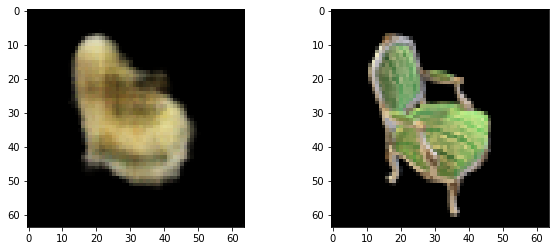

[401] SSIM: 0.437
[402] SSIM: 0.404
[403] SSIM: 0.509
[404] SSIM: 0.469
[405] SSIM: 0.466
[406] SSIM: 0.443
[407] SSIM: 0.471
[408] SSIM: 0.481
[409] SSIM: 0.482
[410] SSIM: 0.460
[411] SSIM: 0.441
[412] SSIM: 0.452
[413] SSIM: 0.456
[414] SSIM: 0.417
[415] SSIM: 0.462
[416] SSIM: 0.521
[417] SSIM: 0.506
[418] SSIM: 0.445
[419] SSIM: 0.469
[420] SSIM: 0.457
[421] SSIM: 0.465
[422] SSIM: 0.450
[423] SSIM: 0.464
[424] SSIM: 0.549
[425] SSIM: 0.458


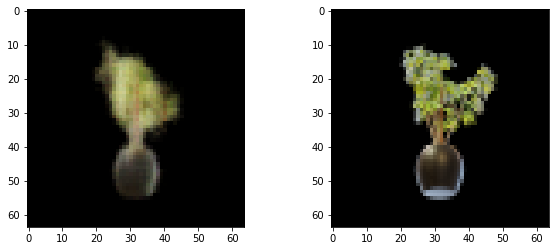

[426] SSIM: 0.539
[427] SSIM: 0.501
[428] SSIM: 0.492
[429] SSIM: 0.448
[430] SSIM: 0.481
[431] SSIM: 0.418
[432] SSIM: 0.481
[433] SSIM: 0.530
[434] SSIM: 0.434
[435] SSIM: 0.502
[436] SSIM: 0.482
[437] SSIM: 0.541
[438] SSIM: 0.569
[439] SSIM: 0.508
[440] SSIM: 0.559
[441] SSIM: 0.474
[442] SSIM: 0.454
[443] SSIM: 0.453
[444] SSIM: 0.577
[445] SSIM: 0.494
[446] SSIM: 0.552
[447] SSIM: 0.446
[448] SSIM: 0.423
[449] SSIM: 0.444
[450] SSIM: 0.487


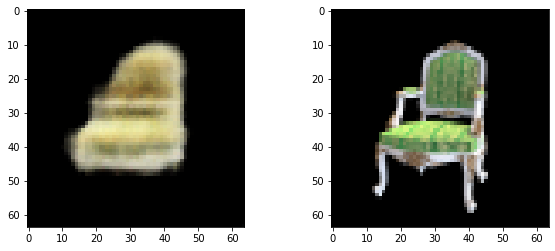

[451] SSIM: 0.516
[452] SSIM: 0.500
[453] SSIM: 0.503
[454] SSIM: 0.411
[455] SSIM: 0.541
[456] SSIM: 0.434
[457] SSIM: 0.499
[458] SSIM: 0.473
[459] SSIM: 0.438
[460] SSIM: 0.467
[461] SSIM: 0.494
[462] SSIM: 0.504
[463] SSIM: 0.508
[464] SSIM: 0.491
[465] SSIM: 0.546
[466] SSIM: 0.388
[467] SSIM: 0.414
[468] SSIM: 0.478
[469] SSIM: 0.464
[470] SSIM: 0.521
[471] SSIM: 0.511
[472] SSIM: 0.440
[473] SSIM: 0.505
[474] SSIM: 0.432
[475] SSIM: 0.482


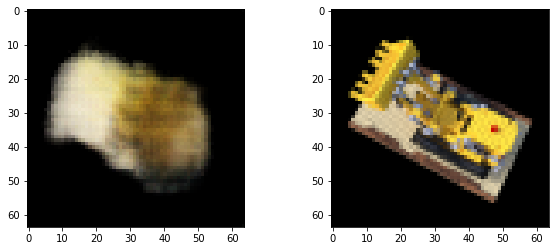

[476] SSIM: 0.485
[477] SSIM: 0.544
[478] SSIM: 0.466
[479] SSIM: 0.468
[480] SSIM: 0.503
[481] SSIM: 0.523
[482] SSIM: 0.597
[483] SSIM: 0.486
[484] SSIM: 0.496
[485] SSIM: 0.543
[486] SSIM: 0.585
[487] SSIM: 0.514
[488] SSIM: 0.484
[489] SSIM: 0.550
[490] SSIM: 0.540
[491] SSIM: 0.512
[492] SSIM: 0.484
[493] SSIM: 0.535
[494] SSIM: 0.514
[495] SSIM: 0.464
[496] SSIM: 0.462
[497] SSIM: 0.549
[498] SSIM: 0.512
[499] SSIM: 0.498
[500] SSIM: 0.459


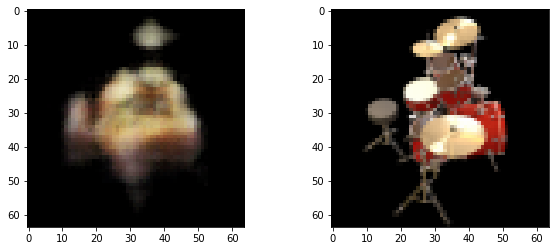

[501] SSIM: 0.551
[502] SSIM: 0.555
[503] SSIM: 0.540
[504] SSIM: 0.537
[505] SSIM: 0.494
[506] SSIM: 0.525
[507] SSIM: 0.543
[508] SSIM: 0.418
[509] SSIM: 0.471
[510] SSIM: 0.517
[511] SSIM: 0.489
[512] SSIM: 0.538
[513] SSIM: 0.432
[514] SSIM: 0.559
[515] SSIM: 0.585
[516] SSIM: 0.549
[517] SSIM: 0.559
[518] SSIM: 0.541
[519] SSIM: 0.491
[520] SSIM: 0.566
[521] SSIM: 0.448
[522] SSIM: 0.586
[523] SSIM: 0.542
[524] SSIM: 0.566
[525] SSIM: 0.564


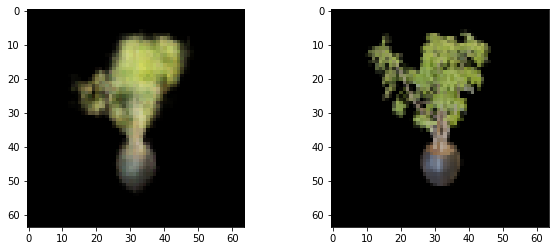

[526] SSIM: 0.509
[527] SSIM: 0.552
[528] SSIM: 0.535
[529] SSIM: 0.523
[530] SSIM: 0.494
[531] SSIM: 0.564
[532] SSIM: 0.569
[533] SSIM: 0.608
[534] SSIM: 0.508
[535] SSIM: 0.510
[536] SSIM: 0.579
[537] SSIM: 0.488
[538] SSIM: 0.482
[539] SSIM: 0.518
[540] SSIM: 0.529
[541] SSIM: 0.507
[542] SSIM: 0.463
[543] SSIM: 0.559
[544] SSIM: 0.561
[545] SSIM: 0.484
[546] SSIM: 0.518
[547] SSIM: 0.506
[548] SSIM: 0.515
[549] SSIM: 0.506
[550] SSIM: 0.548


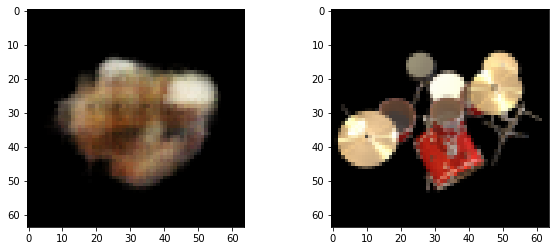

[551] SSIM: 0.488
[552] SSIM: 0.480
[553] SSIM: 0.601
[554] SSIM: 0.634
[555] SSIM: 0.543
[556] SSIM: 0.503
[557] SSIM: 0.504
[558] SSIM: 0.530
[559] SSIM: 0.525
[560] SSIM: 0.598
[561] SSIM: 0.519
[562] SSIM: 0.564
[563] SSIM: 0.540
[564] SSIM: 0.574
[565] SSIM: 0.520
[566] SSIM: 0.516
[567] SSIM: 0.516
[568] SSIM: 0.425
[569] SSIM: 0.464
[570] SSIM: 0.543
[571] SSIM: 0.495
[572] SSIM: 0.451
[573] SSIM: 0.511
[574] SSIM: 0.529
[575] SSIM: 0.516


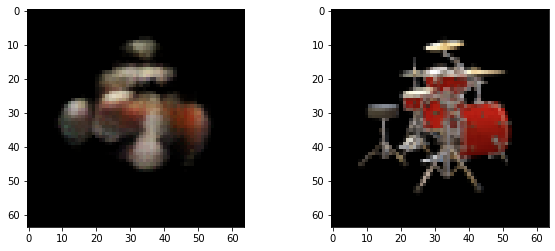

[576] SSIM: 0.522
[577] SSIM: 0.514
[578] SSIM: 0.483
[579] SSIM: 0.551
[580] SSIM: 0.569
[581] SSIM: 0.543
[582] SSIM: 0.581
[583] SSIM: 0.532
[584] SSIM: 0.508
[585] SSIM: 0.530
[586] SSIM: 0.488
[587] SSIM: 0.493
[588] SSIM: 0.538
[589] SSIM: 0.532
[590] SSIM: 0.490
[591] SSIM: 0.558
[592] SSIM: 0.548
[593] SSIM: 0.481
[594] SSIM: 0.541
[595] SSIM: 0.518
[596] SSIM: 0.524
[597] SSIM: 0.562
[598] SSIM: 0.508
[599] SSIM: 0.518
[600] SSIM: 0.543


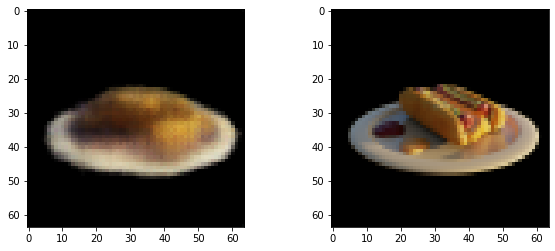

[601] SSIM: 0.502
[602] SSIM: 0.515
[603] SSIM: 0.553
[604] SSIM: 0.578
[605] SSIM: 0.548
[606] SSIM: 0.585
[607] SSIM: 0.549
[608] SSIM: 0.561
[609] SSIM: 0.586
[610] SSIM: 0.517
[611] SSIM: 0.549
[612] SSIM: 0.530
[613] SSIM: 0.621
[614] SSIM: 0.575
[615] SSIM: 0.525
[616] SSIM: 0.580
[617] SSIM: 0.555
[618] SSIM: 0.569
[619] SSIM: 0.517
[620] SSIM: 0.527
[621] SSIM: 0.599
[622] SSIM: 0.562
[623] SSIM: 0.554
[624] SSIM: 0.525
[625] SSIM: 0.592


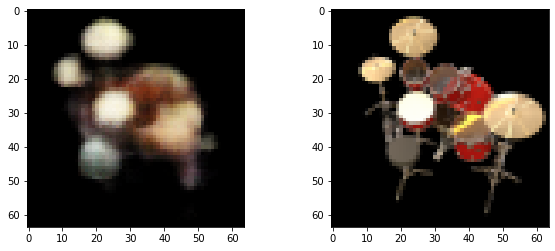

[626] SSIM: 0.572
[627] SSIM: 0.538
[628] SSIM: 0.581
[629] SSIM: 0.575
[630] SSIM: 0.603
[631] SSIM: 0.538
[632] SSIM: 0.485
[633] SSIM: 0.615
[634] SSIM: 0.609
[635] SSIM: 0.604
[636] SSIM: 0.575
[637] SSIM: 0.539
[638] SSIM: 0.575
[639] SSIM: 0.584
[640] SSIM: 0.608
[641] SSIM: 0.579
[642] SSIM: 0.588
[643] SSIM: 0.528
[644] SSIM: 0.598
[645] SSIM: 0.567
[646] SSIM: 0.545
[647] SSIM: 0.586
[648] SSIM: 0.569
[649] SSIM: 0.540
[650] SSIM: 0.570


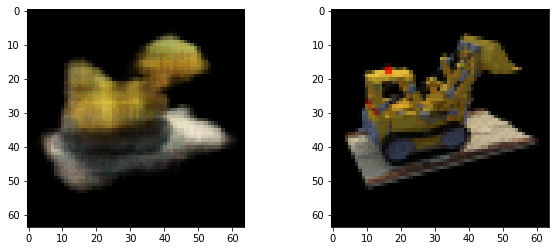

[651] SSIM: 0.535
[652] SSIM: 0.613
[653] SSIM: 0.573
[654] SSIM: 0.552
[655] SSIM: 0.633
[656] SSIM: 0.550
[657] SSIM: 0.541
[658] SSIM: 0.518
[659] SSIM: 0.575
[660] SSIM: 0.529
[661] SSIM: 0.573
[662] SSIM: 0.585
[663] SSIM: 0.548
[664] SSIM: 0.547
[665] SSIM: 0.588
[666] SSIM: 0.504
[667] SSIM: 0.560
[668] SSIM: 0.541
[669] SSIM: 0.553
[670] SSIM: 0.551
[671] SSIM: 0.598
[672] SSIM: 0.523
[673] SSIM: 0.578
[674] SSIM: 0.556
[675] SSIM: 0.528


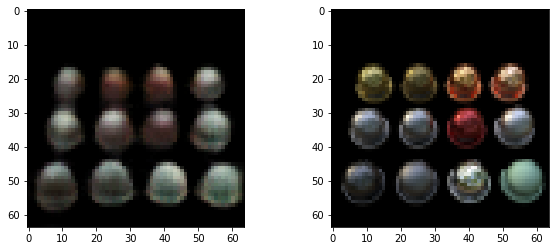

[676] SSIM: 0.575
[677] SSIM: 0.538
[678] SSIM: 0.559
[679] SSIM: 0.522
[680] SSIM: 0.557
[681] SSIM: 0.606
[682] SSIM: 0.542
[683] SSIM: 0.574
[684] SSIM: 0.542
[685] SSIM: 0.599
[686] SSIM: 0.608
[687] SSIM: 0.570
[688] SSIM: 0.576
[689] SSIM: 0.569
[690] SSIM: 0.627
[691] SSIM: 0.589
[692] SSIM: 0.582
[693] SSIM: 0.581
[694] SSIM: 0.521
[695] SSIM: 0.573
[696] SSIM: 0.603
[697] SSIM: 0.596
[698] SSIM: 0.533
[699] SSIM: 0.617
[700] SSIM: 0.576


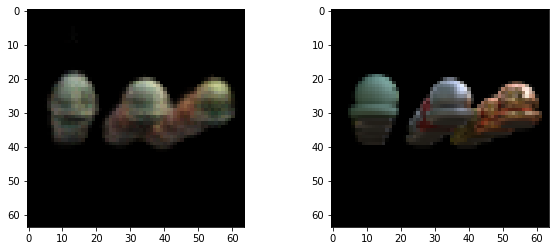

[701] SSIM: 0.506
[702] SSIM: 0.577
[703] SSIM: 0.577
[704] SSIM: 0.534
[705] SSIM: 0.575
[706] SSIM: 0.540
[707] SSIM: 0.592
[708] SSIM: 0.576
[709] SSIM: 0.492
[710] SSIM: 0.591
[711] SSIM: 0.568
[712] SSIM: 0.637
[713] SSIM: 0.602
[714] SSIM: 0.538
[715] SSIM: 0.533
[716] SSIM: 0.593
[717] SSIM: 0.583
[718] SSIM: 0.600
[719] SSIM: 0.604
[720] SSIM: 0.583
[721] SSIM: 0.591
[722] SSIM: 0.570
[723] SSIM: 0.590
[724] SSIM: 0.597
[725] SSIM: 0.587


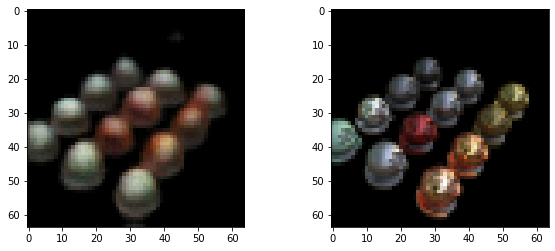

[726] SSIM: 0.605
[727] SSIM: 0.638
[728] SSIM: 0.598
[729] SSIM: 0.606
[730] SSIM: 0.625
[731] SSIM: 0.596
[732] SSIM: 0.610
[733] SSIM: 0.479
[734] SSIM: 0.535
[735] SSIM: 0.535
[736] SSIM: 0.550
[737] SSIM: 0.596
[738] SSIM: 0.574
[739] SSIM: 0.602
[740] SSIM: 0.569
[741] SSIM: 0.550
[742] SSIM: 0.604
[743] SSIM: 0.590
[744] SSIM: 0.565
[745] SSIM: 0.577
[746] SSIM: 0.619
[747] SSIM: 0.624
[748] SSIM: 0.612
[749] SSIM: 0.598
[750] SSIM: 0.626


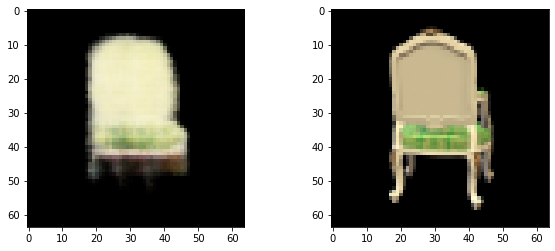

[751] SSIM: 0.565
[752] SSIM: 0.608
[753] SSIM: 0.608
[754] SSIM: 0.597
[755] SSIM: 0.604
[756] SSIM: 0.545
[757] SSIM: 0.550
[758] SSIM: 0.601
[759] SSIM: 0.631
[760] SSIM: 0.600
[761] SSIM: 0.585
[762] SSIM: 0.628
[763] SSIM: 0.601
[764] SSIM: 0.589
[765] SSIM: 0.614
[766] SSIM: 0.622
[767] SSIM: 0.570
[768] SSIM: 0.559
[769] SSIM: 0.635
[770] SSIM: 0.597
[771] SSIM: 0.604
[772] SSIM: 0.604
[773] SSIM: 0.608
[774] SSIM: 0.620
[775] SSIM: 0.592


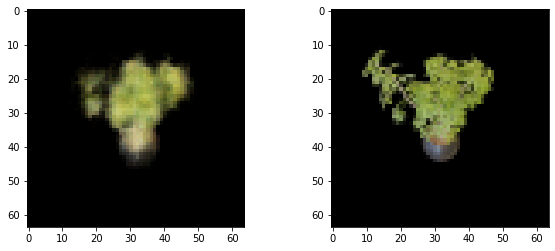

[776] SSIM: 0.614
[777] SSIM: 0.635
[778] SSIM: 0.626
[779] SSIM: 0.538
[780] SSIM: 0.632
[781] SSIM: 0.653
[782] SSIM: 0.629
[783] SSIM: 0.655
[784] SSIM: 0.579
[785] SSIM: 0.595
[786] SSIM: 0.655
[787] SSIM: 0.630
[788] SSIM: 0.617
[789] SSIM: 0.620
[790] SSIM: 0.639
[791] SSIM: 0.549
[792] SSIM: 0.593
[793] SSIM: 0.649
[794] SSIM: 0.625
[795] SSIM: 0.617
[796] SSIM: 0.627
[797] SSIM: 0.580
[798] SSIM: 0.620
[799] SSIM: 0.643
[800] SSIM: 0.606


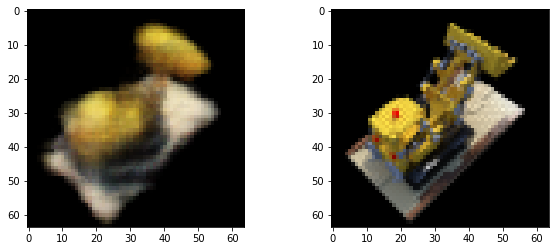

[801] SSIM: 0.614
[802] SSIM: 0.581
[803] SSIM: 0.601
[804] SSIM: 0.595
[805] SSIM: 0.685
[806] SSIM: 0.583
[807] SSIM: 0.482
[808] SSIM: 0.611
[809] SSIM: 0.564
[810] SSIM: 0.585
[811] SSIM: 0.619
[812] SSIM: 0.557
[813] SSIM: 0.616
[814] SSIM: 0.585
[815] SSIM: 0.616
[816] SSIM: 0.635
[817] SSIM: 0.609
[818] SSIM: 0.649
[819] SSIM: 0.618
[820] SSIM: 0.614
[821] SSIM: 0.625
[822] SSIM: 0.545
[823] SSIM: 0.642
[824] SSIM: 0.606
[825] SSIM: 0.595


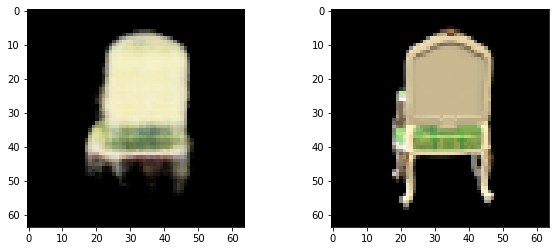

[826] SSIM: 0.618
[827] SSIM: 0.570
[828] SSIM: 0.648
[829] SSIM: 0.630
[830] SSIM: 0.562
[831] SSIM: 0.599
[832] SSIM: 0.632
[833] SSIM: 0.616
[834] SSIM: 0.631
[835] SSIM: 0.613
[836] SSIM: 0.579
[837] SSIM: 0.603
[838] SSIM: 0.580
[839] SSIM: 0.632
[840] SSIM: 0.578
[841] SSIM: 0.569
[842] SSIM: 0.604
[843] SSIM: 0.592
[844] SSIM: 0.568
[845] SSIM: 0.631
[846] SSIM: 0.628
[847] SSIM: 0.614
[848] SSIM: 0.615
[849] SSIM: 0.645
[850] SSIM: 0.664


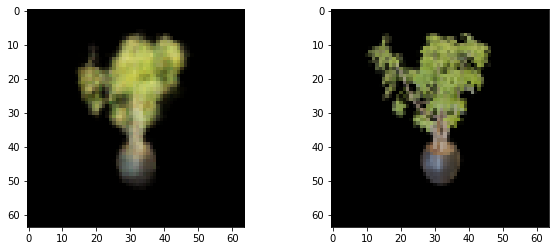

[851] SSIM: 0.642
[852] SSIM: 0.601
[853] SSIM: 0.611
[854] SSIM: 0.635
[855] SSIM: 0.605
[856] SSIM: 0.615
[857] SSIM: 0.607
[858] SSIM: 0.619
[859] SSIM: 0.633
[860] SSIM: 0.629
[861] SSIM: 0.598
[862] SSIM: 0.621
[863] SSIM: 0.627
[864] SSIM: 0.558
[865] SSIM: 0.581
[866] SSIM: 0.585
[867] SSIM: 0.634
[868] SSIM: 0.653
[869] SSIM: 0.593
[870] SSIM: 0.627
[871] SSIM: 0.557
[872] SSIM: 0.630
[873] SSIM: 0.640
[874] SSIM: 0.582
[875] SSIM: 0.569


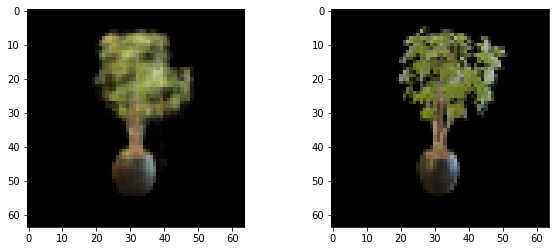

[876] SSIM: 0.608
[877] SSIM: 0.620
[878] SSIM: 0.608
[879] SSIM: 0.609
[880] SSIM: 0.635
[881] SSIM: 0.639
[882] SSIM: 0.581
[883] SSIM: 0.637
[884] SSIM: 0.670
[885] SSIM: 0.598
[886] SSIM: 0.638
[887] SSIM: 0.573
[888] SSIM: 0.639
[889] SSIM: 0.658
[890] SSIM: 0.663
[891] SSIM: 0.608
[892] SSIM: 0.581
[893] SSIM: 0.611
[894] SSIM: 0.606
[895] SSIM: 0.627
[896] SSIM: 0.618
[897] SSIM: 0.633
[898] SSIM: 0.667
[899] SSIM: 0.620
[900] SSIM: 0.630


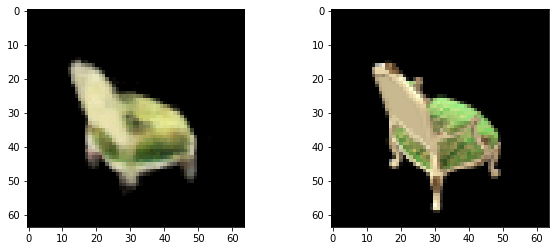

[901] SSIM: 0.604
[902] SSIM: 0.609
[903] SSIM: 0.653
[904] SSIM: 0.651
[905] SSIM: 0.637
[906] SSIM: 0.617
[907] SSIM: 0.660
[908] SSIM: 0.653
[909] SSIM: 0.583
[910] SSIM: 0.651
[911] SSIM: 0.599
[912] SSIM: 0.615
[913] SSIM: 0.587
[914] SSIM: 0.636
[915] SSIM: 0.616
[916] SSIM: 0.630
[917] SSIM: 0.627
[918] SSIM: 0.634
[919] SSIM: 0.590
[920] SSIM: 0.611
[921] SSIM: 0.629
[922] SSIM: 0.657
[923] SSIM: 0.655
[924] SSIM: 0.622
[925] SSIM: 0.657


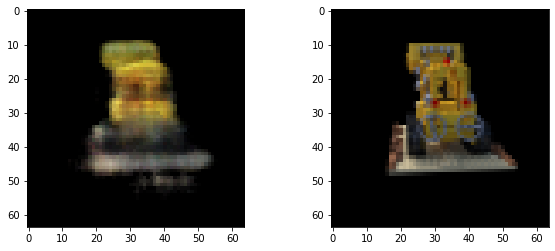

[926] SSIM: 0.634
[927] SSIM: 0.630
[928] SSIM: 0.593
[929] SSIM: 0.632
[930] SSIM: 0.630
[931] SSIM: 0.659
[932] SSIM: 0.598
[933] SSIM: 0.643
[934] SSIM: 0.629
[935] SSIM: 0.658
[936] SSIM: 0.633
[937] SSIM: 0.663
[938] SSIM: 0.635
[939] SSIM: 0.617
[940] SSIM: 0.617
[941] SSIM: 0.645
[942] SSIM: 0.645
[943] SSIM: 0.668
[944] SSIM: 0.665
[945] SSIM: 0.662
[946] SSIM: 0.632
[947] SSIM: 0.640
[948] SSIM: 0.639
[949] SSIM: 0.646
[950] SSIM: 0.622


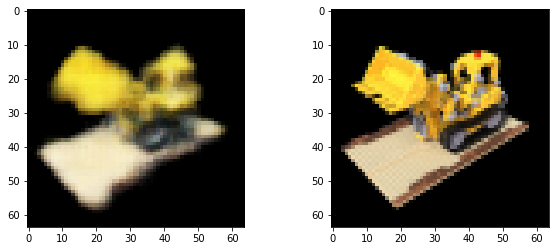

[951] SSIM: 0.651
[952] SSIM: 0.684
[953] SSIM: 0.683
[954] SSIM: 0.601
[955] SSIM: 0.627
[956] SSIM: 0.626
[957] SSIM: 0.643
[958] SSIM: 0.681
[959] SSIM: 0.640
[960] SSIM: 0.637
[961] SSIM: 0.669
[962] SSIM: 0.663
[963] SSIM: 0.631
[964] SSIM: 0.653
[965] SSIM: 0.651
[966] SSIM: 0.646
[967] SSIM: 0.612
[968] SSIM: 0.664
[969] SSIM: 0.623
[970] SSIM: 0.636
[971] SSIM: 0.672
[972] SSIM: 0.638
[973] SSIM: 0.650
[974] SSIM: 0.646
[975] SSIM: 0.619


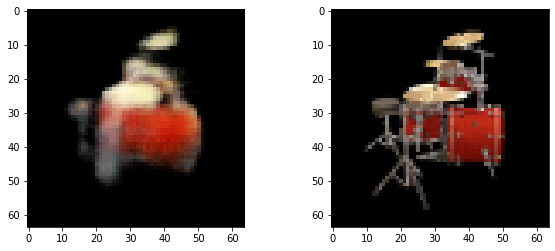

[976] SSIM: 0.668
[977] SSIM: 0.649
[978] SSIM: 0.604
[979] SSIM: 0.634
[980] SSIM: 0.634
[981] SSIM: 0.634
[982] SSIM: 0.639
[983] SSIM: 0.657


RuntimeError: ignored

In [ ]:
epochs = 1000
indices = np.arange(0,400)

for epoch in range(epochs):
  ssim_val = 0

  opt.zero_grad()

  for bidx in range(acc_bz):
    gc.collect()
    torch.cuda.empty_cache()

    random.shuffle(train_objs)
    train_obj = train_objs[0]

    # base_num = 16
    base_num = random.randint(base_num_range[0], base_num_range[1])
    np.random.shuffle(indices)
    base_idx = indices[:base_num]
    target_idx = indices[base_num:base_num+bz]
    
    base_img = torch.tensor(imgs[train_obj][base_idx,:-1,...]).type(torch.FloatTensor).to(device)
    base_img = rearrange(base_img, 'b c H W -> 1 c b H W')
    
    target_img = torch.tensor(imgs[train_obj][target_idx,:-1,...]).type(torch.FloatTensor).to(device)
    target_mask = torch.tensor(imgs[train_obj][target_idx,-1:,...]).type(torch.FloatTensor).to(device)

    # N_samples = 64
    N_samples = random.randint(N_samples_range[0], N_samples_range[1])

    H, W, focal = hwf[train_obj]
    H, W = int(H), int(W)
    
    base_rays_o, base_rays_d = get_rays(H, W, focal, torch.tensor(poses[train_obj][base_idx],device=device))
    base_z_vals = sample_z(near, far, 1, 1, 1, 1)
    base_pts = sample_points(base_rays_o, base_rays_d, base_z_vals)
    base_pos = posenc(base_pts, L_embed)
    base_pos = rearrange(base_pos, 'b e 1 H W -> 1 e b H W')

    target_rays_o, target_rays_d = get_rays(H, W, focal, torch.tensor(poses[train_obj][target_idx],device=device))
    target_z_vals = sample_z(near, far, N_samples, 1, 1, bz, True)
    target_pts = sample_points(target_rays_o, target_rays_d, target_z_vals)
    target_pos = posenc(target_pts, L_embed)

    q = q_net(target_pos)
    k = k_net(base_pos)
    v = v_net(base_img)
    mu, logvar = mapping(q, k, v, head_num)
    z = reparameterize(mu, logvar)
    rgba = dec_net(z)

    rgb = torch.sigmoid(rgba[:,:3,...])
    sigma_a = F.relu(rgba[:,3:,...])
    
    # Do volume rendering
    dists = torch.cat([target_z_vals[:,:,1:,...] - target_z_vals[:,:,:-1,...], torch.ones(bz, 1, 1, 1, 1, device=device)*1e10], 2) 
    alpha = 1.-torch.exp(-sigma_a * dists)
    _alpha = (1.-alpha + 1e-10)[:,:,:-1,...]
    _alpha = torch.cat([torch.ones(bz, 1, 1, H, W, device=device), _alpha],2)
    weights = alpha * torch.cumprod(_alpha, 2)
    rgb_map = torch.sum(weights * rgb, 2)

    ssim_loss = ssim_fn(rgb_map,target_img,target_mask)*0.8+ssim_fn(rgb_map,target_img,1-target_mask)*0.2
    loss = -ssim_loss+kl_divergence(mu, logvar)
    (loss/acc_bz).backward()
    ssim_val += ssim_loss.item()

  opt.step()

  print('[{}] SSIM: {:.3f}'.format(epoch, ssim_val/acc_bz))
  state = {
      'v_net_state_dict': v_net.state_dict(),
      'k_net_state_dict': k_net.state_dict(),
      'q_net_state_dict': q_net.state_dict(),
      'dec_net_state_dict': dec_net.state_dict(),
      'opt_state_dict': opt.state_dict(),
    }

  torch.save(state, "./decoupling_nerf-vae_state.pt")

  if epoch%25 == 0:
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(np.transpose(rgb_map[0].cpu().detach().numpy(),(1,2,0)))
    plt.subplot(122)
    plt.imshow(np.transpose(target_img[0].cpu().detach().numpy(),(1,2,0)))
    plt.show()
      

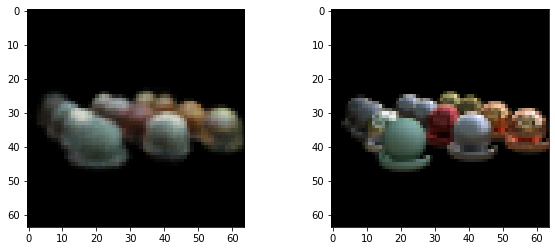

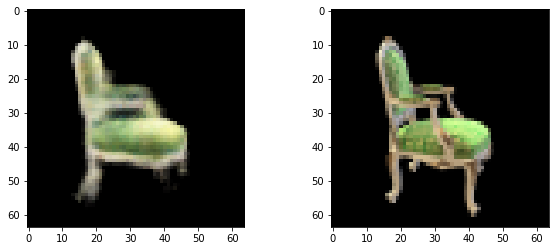

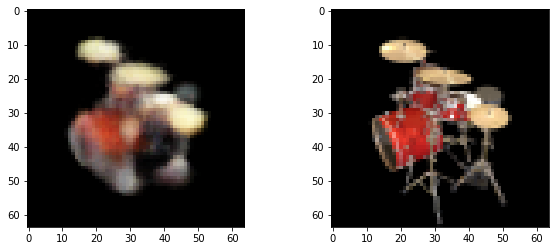

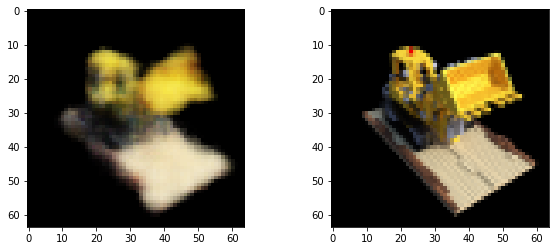

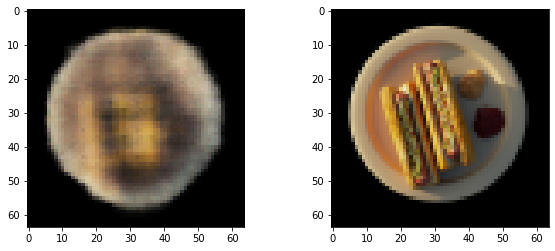

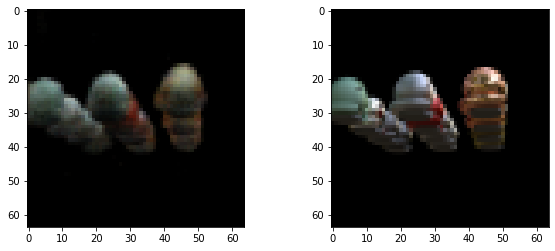

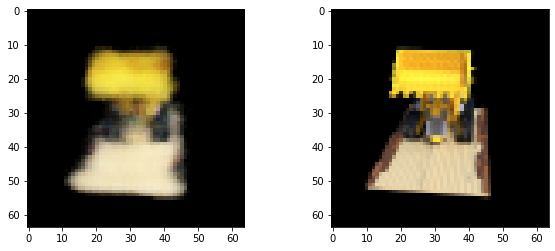

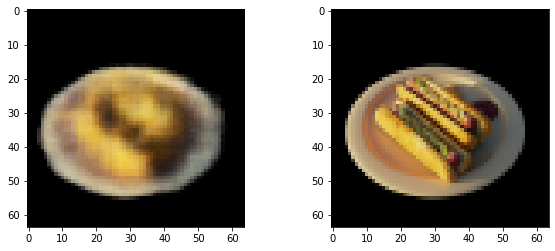

In [ ]:
epochs = 1
indices = np.arange(0,400)
test_objs = objs[:-2]
with torch.no_grad():
  for epoch in range(epochs):

    for bidx in range(acc_bz):
      gc.collect()
      torch.cuda.empty_cache()

      random.shuffle(test_objs)
      test_obj = test_objs[0]

      # base_num = 16
      base_num = random.randint(base_num_range[0], base_num_range[1])
      np.random.shuffle(indices)
      base_idx = indices[:base_num]
      target_idx = indices[base_num:base_num+bz]
      
      base_img = torch.tensor(imgs[test_obj][base_idx,:-1,...]).type(torch.FloatTensor).to(device)
      base_img = rearrange(base_img, 'b c H W -> 1 c b H W')
      
      target_img = torch.tensor(imgs[test_obj][target_idx,:-1,...]).type(torch.FloatTensor).to(device)
      target_mask = torch.tensor(imgs[test_obj][target_idx,-1:,...]).type(torch.FloatTensor).to(device)

      # N_samples = 64
      N_samples = random.randint(N_samples_range[0], N_samples_range[1])

      H, W, focal = hwf[test_obj]
      H, W = int(H), int(W)
      
      base_rays_o, base_rays_d = get_rays(H, W, focal, torch.tensor(poses[test_obj][base_idx],device=device))
      base_z_vals = sample_z(near, far, 1, 1, 1, 1)
      base_pts = sample_points(base_rays_o, base_rays_d, base_z_vals)
      base_pos = posenc(base_pts, L_embed)
      base_pos = rearrange(base_pos, 'b e 1 H W -> 1 e b H W')

      target_rays_o, target_rays_d = get_rays(H, W, focal, torch.tensor(poses[test_obj][target_idx],device=device))
      target_z_vals = sample_z(near, far, N_samples, 1, 1, bz, True)
      target_pts = sample_points(target_rays_o, target_rays_d, target_z_vals)
      target_pos = posenc(target_pts, L_embed)

      q = q_net(target_pos)
      k = k_net(base_pos)
      v = v_net(base_img)
      mu, logvar = mapping(q, k, v, head_num)
      z = reparameterize(mu, logvar)
      rgba = dec_net(z)

      rgb = torch.sigmoid(rgba[:,:3,...])
      sigma_a = F.relu(rgba[:,3:,...])
      
      # Do volume rendering
      dists = torch.cat([target_z_vals[:,:,1:,...] - target_z_vals[:,:,:-1,...], torch.ones(bz, 1, 1, 1, 1, device=device)*1e10], 2) 
      alpha = 1.-torch.exp(-sigma_a * dists)
      _alpha = (1.-alpha + 1e-10)[:,:,:-1,...]
      _alpha = torch.cat([torch.ones(bz, 1, 1, H, W, device=device), _alpha],2)
      weights = alpha * torch.cumprod(_alpha, 2)
      rgb_map = torch.sum(weights * rgb, 2)

      plt.figure(figsize=(10,4))
      plt.subplot(121)
      plt.imshow(np.transpose(rgb_map[0].cpu().detach().numpy(),(1,2,0)))
      plt.subplot(122)
      plt.imshow(np.transpose(target_img[0].cpu().detach().numpy(),(1,2,0)))
      plt.show()
        

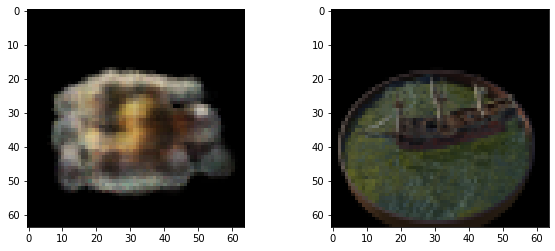

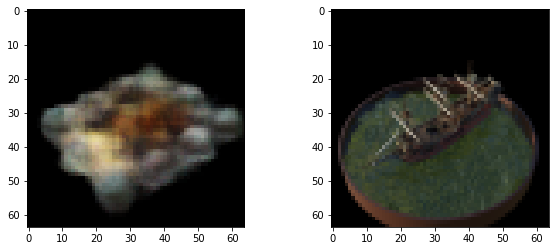

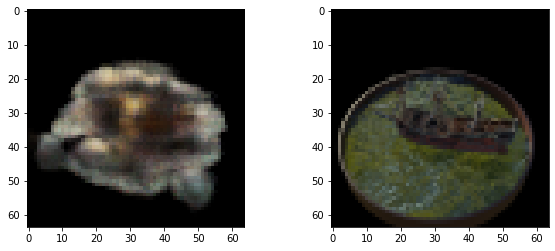

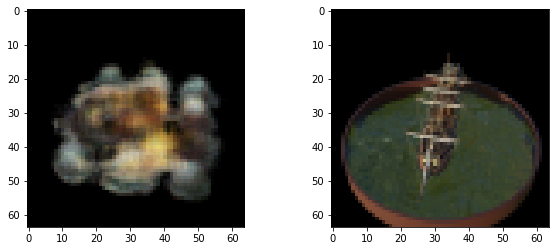

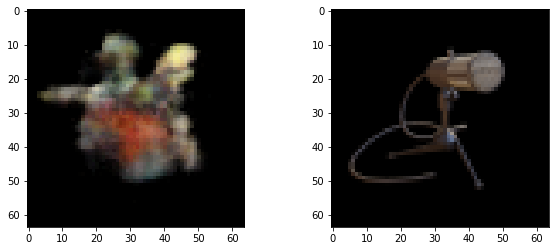

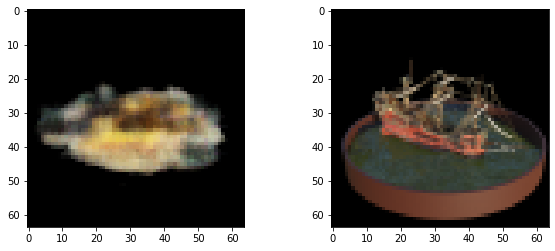

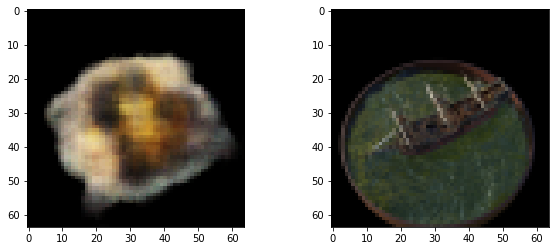

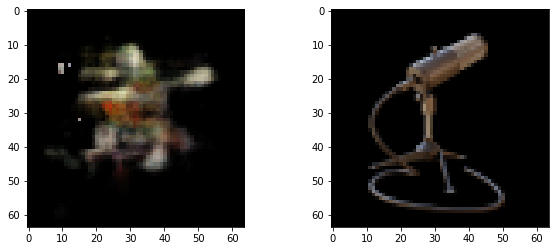

In [ ]:
epochs = 1
indices = np.arange(0,400)
test_objs = objs[-2:]
with torch.no_grad():
  for epoch in range(epochs):

    for bidx in range(acc_bz):
      gc.collect()
      torch.cuda.empty_cache()

      random.shuffle(test_objs)
      test_obj = test_objs[0]

      # base_num = 16
      base_num = random.randint(base_num_range[0], base_num_range[1])
      np.random.shuffle(indices)
      base_idx = indices[:base_num]
      target_idx = indices[base_num:base_num+bz]
      
      base_img = torch.tensor(imgs[test_obj][base_idx,:-1,...]).type(torch.FloatTensor).to(device)
      base_img = rearrange(base_img, 'b c H W -> 1 c b H W')
      
      target_img = torch.tensor(imgs[test_obj][target_idx,:-1,...]).type(torch.FloatTensor).to(device)
      target_mask = torch.tensor(imgs[test_obj][target_idx,-1:,...]).type(torch.FloatTensor).to(device)

      # N_samples = 64
      N_samples = random.randint(N_samples_range[0], N_samples_range[1])

      H, W, focal = hwf[test_obj]
      H, W = int(H), int(W)
      
      base_rays_o, base_rays_d = get_rays(H, W, focal, torch.tensor(poses[test_obj][base_idx],device=device))
      base_z_vals = sample_z(near, far, 1, 1, 1, 1)
      base_pts = sample_points(base_rays_o, base_rays_d, base_z_vals)
      base_pos = posenc(base_pts, L_embed)
      base_pos = rearrange(base_pos, 'b e 1 H W -> 1 e b H W')

      target_rays_o, target_rays_d = get_rays(H, W, focal, torch.tensor(poses[test_obj][target_idx],device=device))
      target_z_vals = sample_z(near, far, N_samples, 1, 1, bz, True)
      target_pts = sample_points(target_rays_o, target_rays_d, target_z_vals)
      target_pos = posenc(target_pts, L_embed)

      q = q_net(target_pos)
      k = k_net(base_pos)
      v = v_net(base_img)
      mu, logvar = mapping(q, k, v, head_num)
      z = reparameterize(mu, logvar)
      rgba = dec_net(z)

      rgb = torch.sigmoid(rgba[:,:3,...])
      sigma_a = F.relu(rgba[:,3:,...])
      
      # Do volume rendering
      dists = torch.cat([target_z_vals[:,:,1:,...] - target_z_vals[:,:,:-1,...], torch.ones(bz, 1, 1, 1, 1, device=device)*1e10], 2) 
      alpha = 1.-torch.exp(-sigma_a * dists)
      _alpha = (1.-alpha + 1e-10)[:,:,:-1,...]
      _alpha = torch.cat([torch.ones(bz, 1, 1, H, W, device=device), _alpha],2)
      weights = alpha * torch.cumprod(_alpha, 2)
      rgb_map = torch.sum(weights * rgb, 2)

      plt.figure(figsize=(10,4))
      plt.subplot(121)
      plt.imshow(np.transpose(rgb_map[0].cpu().detach().numpy(),(1,2,0)))
      plt.subplot(122)
      plt.imshow(np.transpose(target_img[0].cpu().detach().numpy(),(1,2,0)))
      plt.show()
        

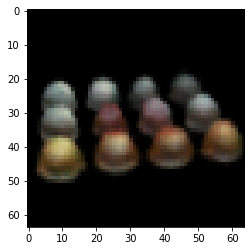

In [ ]:
plt.imshow(np.transpose(rgb_map[1].cpu().detach().numpy(),(1,2,0)))
plt.show()

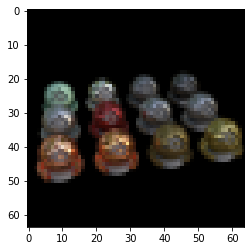

In [ ]:
plt.imshow(np.transpose(target_img[1].cpu().detach().numpy(),(1,2,0)))
plt.show()